In [1]:
import matplotlib.pyplot as plt
import numpy as np

In [8]:
import torch
import pytorch_lightning as pl
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from pytorch_lightning.loggers import TensorBoardLogger
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [10]:
from field_setup import N_nod, Beta, K_nod, L_nod
from transforms import t_get_O
from transforms import get_split_masks
from transforms import get_pair_split_masks
from transforms import config_RG_masks
from Data import MY_Dataset
from flows.NormalizingFlow import NormalizingFlow    
from flows.RGflows import RGflows    
from obs import G, calc_Loss, calc_psi2, gen_fun_W


def set_random_seed(seed):
    torch.manual_seed(seed)
    np.random.seed(seed)

set_random_seed(42)





In [12]:
from field_setup import scalar, phi4, Scalar_Field, Phi4
O_latt = t_get_O(L_nod)

In [14]:
normal_dist = torch.distributions.Normal(loc=torch.zeros(N_nod,scalar.dim), scale=torch.ones(N_nod,scalar.dim))
DS=MY_Dataset(normal_dist,N_nod,epoch_size=2**16)
train_loader = DataLoader(DS, batch_size=2**12, shuffle=True)

In [16]:
class Pipeline(pl.LightningModule):
    def __init__(
        self,
        model,
        latent,
        criterion,
        optimizer_class=torch.optim.Adam,
        optimizer_kwargs={"lr": 0.001,"weight_decay": 0}
    ) -> None:
        super().__init__()
        self.model = model
        self.loss = criterion
        self.latent = latent
        self.optimizer_class = optimizer_class
        self.optimizer_kwargs = optimizer_kwargs

    """
    def configure_optimizers(self):
        optimizer = self.optimizer_class(
            self.model.parameters(), **self.optimizer_kwargs
        )
        return optimizer
    """
    
    def configure_optimizers(self):
        optimizer = self.optimizer_class(self.model.parameters(), **self.optimizer_kwargs)
        
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
            optimizer=optimizer,
            min_lr=1e-5,
            factor=0.95,
            mode="min",
            verbose=True,
        )

        lr_scheduler = {
            "scheduler": scheduler,
            "interval": "epoch",
            "monitor": "train_loss",
        }
        return [optimizer], [lr_scheduler]

    def training_step(self, batch, batch_idx):
        z = batch
        latent_log_prob = torch.sum(self.latent.log_prob(z),(1,2))
        
        x, log_abs_det = self.model.g(z)
        loss = self.loss(x,log_abs_det)
        ess = self.loss.ESS(latent_log_prob,log_abs_det)

        
        sch = self.lr_schedulers()
        sch.step(loss)
        self.log('train_loss', loss,prog_bar=True)
        self.log('ess',ess)
        self.log('mean_x',torch.mean(x))
        self.log('lr',sch.get_last_lr()[0])
        return loss


    def on_train_epoch_end(self):
        #print("---------------------------end epoch---------------------------------")
        pass
    
    def on_validation_end(self) -> None:
        if not self.automatic_optimization:
            # Save a checkpoint of the model
            ckpt_path = os.path.join(self.trainer.log_dir, 'checkpoints', 'ckpt.pt')
            self.trainer.save_checkpoint(ckpt_path, weights_only=True)
        return super().on_validation_end()
    
    

In [18]:
hidden_dim_dict1={8:256}
n_flows_dict1={8:6}
num_hidden_dict1={8:6}

In [20]:
m = 3
RGmasks=config_RG_masks(m,N_nod)

In [22]:
set_random_seed(42)
rg = RGflows.configure_RG_model(RGmasks,n_flows_dict1,num_hidden_dict1,hidden_dim_dict1,grids_no_grad=0,p_drop=0.0,sys_dim = scalar.dim, O_latt = O_latt)
#rg.save("./weights/field/phi4.pth")

In [24]:
beta_arr = [16,4,1,1/4,1/16]

In [ ]:
set_random_seed(42)
phi4.set_J_local(1,16)
phi4.mass2 = 1
for i in range(len(beta_arr)):
    
    phi4.beta = beta_arr[i]
    pipeline = Pipeline(model = rg, 
                  latent = normal_dist ,
                  criterion = phi4.get_KL(), 
                  optimizer_class=torch.optim.Adam,
                  optimizer_kwargs={"lr": 0.001,"weight_decay":0.0})

    trainer = pl.Trainer(
        max_epochs = 15,
        logger = TensorBoardLogger(save_dir=f"./logs/field_phi4_beta"),
        num_sanity_val_steps = 0,
        log_every_n_steps = 1,
        enable_checkpointing = False,
        accumulate_grad_batches = 1)

    trainer.fit(model=pipeline, train_dataloaders=train_loader)
    rg.save("./weights/field/phi4_beta_jloc/phi4_beta_jloc"+str(beta_arr[i])+".pth")

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
C:\Users\SEVA1\anaconda3\Lib\site-packages\torch\optim\lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "

  | Name  | Type      | Params | Mode 
--------------------------------------------
0 | model | RGflows   | 3.0 M  | train
1 | loss  | KL_with_S | 0      | train
--------------------------------------------
3.0 M     Trainable params
0         Non-trainable params
3.0 M     Total params
11.993    Total estimated model params size (MB)
C:\Users\SEVA1\anaconda3\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=3` in the `DataLoader` to improve 

Training: |                                                                                      | 0/? [00:00<…

C:\Users\SEVA1\anaconda3\Lib\site-packages\pytorch_lightning\trainer\call.py:54: Detected KeyboardInterrupt, attempting graceful shutdown...
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name  | Type      | Params | Mode 
--------------------------------------------
0 | model | RGflows   | 3.0 M  | train
1 | loss  | KL_with_S | 0      | train
--------------------------------------------
3.0 M     Trainable params
0         Non-trainable params
3.0 M     Total params
11.993    Total estimated model params size (MB)


Training: |                                                                                      | 0/? [00:00<…

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name  | Type      | Params | Mode 
--------------------------------------------
0 | model | RGflows   | 3.0 M  | train
1 | loss  | KL_with_S | 0      | train
--------------------------------------------
3.0 M     Trainable params
0         Non-trainable params
3.0 M     Total params
11.993    Total estimated model params size (MB)


Training: |                                                                                      | 0/? [00:00<…

In [48]:
set_random_seed(42)
scalar.set_J_local(4,16)
phi4.set_J_local(4,16)
pipeline=Pipeline(model=rg, 
                  latent = normal_dist ,
                  criterion = phi4.get_KL(), 
                  optimizer_class=torch.optim.Adam,
                  optimizer_kwargs={"lr": 0.001,"weight_decay":0.0})

trainer = pl.Trainer(
    max_epochs = 2000,
    logger = TensorBoardLogger(save_dir=f"./logs/field"),
    num_sanity_val_steps = 0,
    log_every_n_steps = 1,
    enable_checkpointing = False,
    accumulate_grad_batches = 1
)

trainer.fit(model=pipeline, train_dataloaders=train_loader)
rg.save("./weights/field/phi4_beta_jloc/phi4_beta_jloc16.pth")

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name  | Type      | Params | Mode 
--------------------------------------------
0 | model | RGflows   | 3.0 M  | train
1 | loss  | KL_with_S | 0      | train
--------------------------------------------
3.0 M     Trainable params
0         Non-trainable params
3.0 M     Total params
11.993    Total estimated model params size (MB)


Training: |                                                                                      | 0/? [00:00<…

In [76]:
#RG_trained = RGflows.load_model("./weights/model_weights_phi4.pth")
fr = RGflows.load_model("./weights/field/free_jloc.pth")
p4 = RGflows.load_model("./weights/field/phi4_beta_jloc/phi4_beta_jloc16.pth")
fr.eval()
p4.eval()
N_traj = 10000
z1 = normal_dist.sample((N_traj,))
z2 = z1.clone()
free , _ = fr.g(z1)
ph4 , _ = p4.g(z2)


In [77]:
mean_free = torch.mean(free,dim=(0,1)).detach()
std_free = (torch.std(free,dim=(0,1)) * (free.shape[0] * free.shape[1]) ** (-0.5)).detach()
mean_int = torch.mean(ph4,dim=(0,1)).detach()
std_int = (torch.std(ph4,dim=(0,1)) * (ph4.shape[0] * ph4.shape[1]) ** (-0.5)).detach()

In [52]:
print(phi4.beta)

16


In [18]:
Mean=[]
Std=[]
for i in range(1):
    RG_trained = RGflows.load_model("./weights/field/phi4_beta_jloc/phi4_beta_jloc"+str(beta_arr[i])+".pth")
    RG_trained.eval()
    N_traj = 20000
    z = normal_dist.sample((N_traj,))
    trajs , _ = RG_trained.g(z)
    mean = -torch.mean(trajs,dim=(0,1)).detach()
    std = (torch.std(trajs,dim=(0,1)) * (trajs.shape[0] * trajs.shape[1]) ** (-0.5)).detach()
    Mean.append(mean)
    Std.append(std)

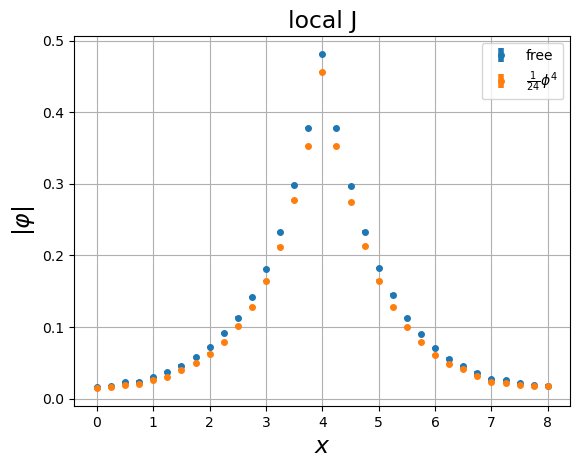

In [116]:
plt.figure()

ls='dotted'
plt.errorbar(33/32 * phi4.h * np.arange(33),-mean_free,std_free,capsize=0,elinewidth=4,marker='o',markersize=4,linestyle='none')
plt.errorbar(33/32 * phi4.h * np.arange(33),-mean_int,std_int,capsize=0,elinewidth=4,marker='o',markersize=4,linestyle='none')
plt.grid(True)
plt.xlabel(r"$x$",fontsize=17)
plt.ylabel(r"$|\varphi|$",fontsize=17)
plt.savefig("../pictures/loc_J.png")
#plt.yscale('log')
plt.legend(['free',r'$\frac{1}{24}\phi^4$'])
plt.title('local J',fontsize=17)
plt.savefig('../pictures/local j.pdf')
plt.show()